In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import warnings
from datetime import datetime

warnings.simplefilter('ignore')
%matplotlib inline

# Загрузка и представление данных

In [2]:
# Функция загрузки данных (для обучения и прогноза)
def init_data(col_for_prediction, sample_ind='sample'):
    df_train = pd.read_csv('train.csv')
    df_pred = pd.read_csv('test.csv')
    df_train[sample_ind] = 1  # train+test
    df_pred[sample_ind] = 0  # предсказание
    df_pred[col_for_prediction] = 0  # выход
    data = df_train.append(df_pred, sort=False).reset_index(drop=True)
    return data


data = init_data(col_for_prediction='default', sample_ind='sample')

In [3]:
# Функция описания табличных данных (Nans, дубли, частоты значений, описательная статистика)
def data_stats_table(data, data_example=True, nlargest_num=1, stats_describe=True):
    data_stats = pd.DataFrame()

    if data_example:  # пример данных
        data_stats['data[0]'] = data.loc[0, :].T

    data_stats['dtypes'] = data.dtypes  # типы переменных
    data_stats.loc['rows_count', 'dtypes'] = len(data.dtypes)

    # расчет количества дублей
    data_stats['dupl'] = int(data.duplicated().sum())

    data_stats['NaNs'] = data.isnull().sum()  # Расчет количества NaNs
    data_stats.loc['rows_count', 'NaNs'] = (
        data.isnull().sum(axis=1) != 0).sum()
    data_stats['NaNs'] = data_stats['NaNs'].astype('int')

    # Расчет частот уникальных значений (частоты нормированы)
    for name in data.columns:
        data_stats.loc[name, 'unique'] = data[name].nunique()
        top_freq = round(data[name].value_counts(
            normalize=True).nlargest(nlargest_num), 2)
        data_stats.loc[name, 'top_freq'] = json.dumps(list(top_freq))
        data_stats.loc[name, 'top_freq_value'] = json.dumps(
            list(top_freq.index))

    if stats_describe:  # описательная статистика
        df_des = round(data.describe().T.drop(columns=['count']), 2)
        data_stats = pd.concat([data_stats, df_des], axis=1, sort=False)

    data_stats.fillna("", inplace=True)

    return data_stats


data_stats_table(data, nlargest_num=3)

,data[0],dtypes,dupl,NaNs,unique,top_freq,top_freq_value,mean,std,min,25%,50%,75%,max
client_id,25905,int64,0,0,110148,"[0.0, 0.0, 0.0]","[2047, 97541, 93447]",55074.5,31797.1,1,27537.8,55074.5,82611.2,110148
app_date,01FEB2014,object,0,0,120,"[0.01, 0.01, 0.01]","[""18MAR2014"", ""19MAR2014"", ""17MAR2014""]",,,,,,,
education,SCH,object,0,478,5,"[0.53, 0.32, 0.13]","[""SCH"", ""GRD"", ""UGR""]",,,,,,,
sex,M,object,0,0,2,"[0.56, 0.44]","[""F"", ""M""]",,,,,,,
age,62,int64,0,0,52,"[0.04, 0.04, 0.04]","[31, 28, 30]",39.25,11.52,21,30,37,48,72
car,Y,object,0,0,2,"[0.67, 0.33]","[""N"", ""Y""]",,,,,,,
car_type,Y,object,0,0,2,"[0.81, 0.19]","[""N"", ""Y""]",,,,,,,
decline_app_cnt,0,int64,0,0,24,"[0.83, 0.11, 0.03]","[0, 1, 2]",0.27,0.8,0,0,0,0,33
good_work,0,int64,0,0,2,"[0.83, 0.17]","[0, 1]",0.17,0.37,0,0,0,0,1
score_bki,-2.00875,float64,0,0,102618,"[0.0, 0.0, 0.0]","[-1.77526279, -2.1042109, -2.22500363]",-1.9,0.5,-3.62,-2.26,-1.92,-1.57,0.2


### Описание полей
client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту

 - 67% данных для обучения, 33%данных для прогноза (признак "sample")
 - нет дублей
 - есть пропуски в признаке "education", основная частота в признаке "education" это "SCH" (53%)
 - признаки:
    - 'client_id' - служебный
    - 'app_date' - дата в текстовом формате (к месяцу и дню недели применяем target_encoder)
    - 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income' - числовые признаки (в 'income' есть аномально высокие значения, возможно нужно логарифмировать)
    - 'sex', 'car', 'car_type', 'foreign_passport' - текстовые бинарные признаки, применяем label_encoder
    - 'good_work' - числовой бинарный признак
    - 'education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time' - текстовые категориальные признаки, применяем target_encoder

In [4]:
# Заполняем пропуски в education значением с максимальной частотой
data.education.fillna(data.education.value_counts().index[0], inplace=True)

# Визуализация распределений признаков

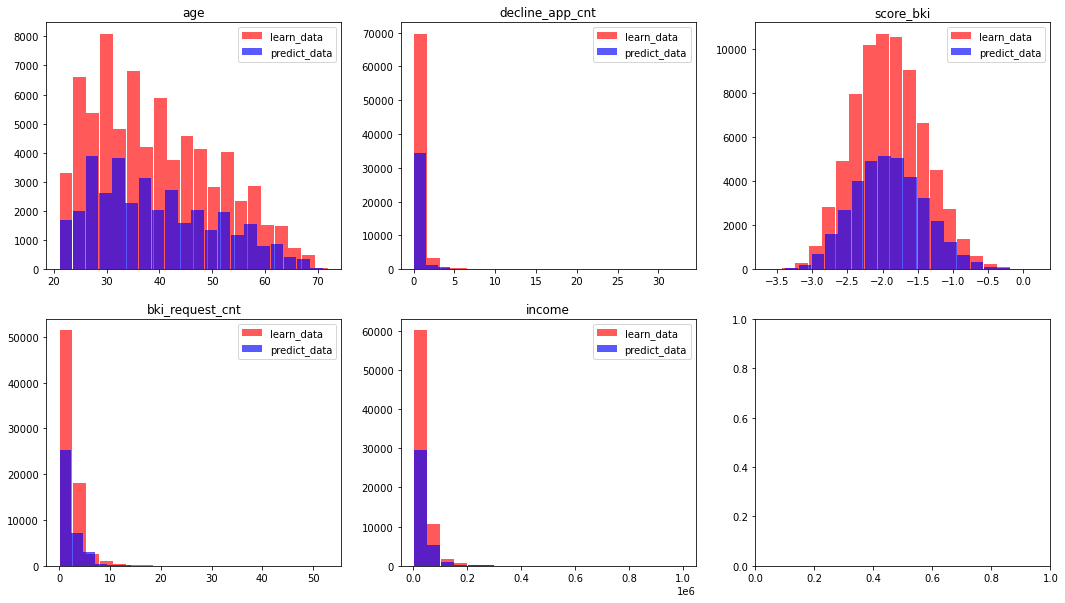

In [5]:
def plot_train_test_hist(data_, col_names, col_number=2, figsize_=(18, 8), bins_=10):
    fig, axes_ = plt.subplots(-(-len(col_names)//col_number),
                              col_number, figsize=figsize_)

    for counter_ in range(len(col_names)):
        pic_row_ = counter_//col_number
        pic_col_ = counter_ % col_number
        axes_[pic_row_, pic_col_].hist(data_[data_['sample'] == 1][col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label='learn_data', color='red', bins=bins_)

        axes_[pic_row_, pic_col_].hist(data_[data_['sample'] == 0][col_names[counter_]], rwidth=0.95,
                                       alpha=0.65, label='predict_data', color='blue', bins=bins_)

        axes_[pic_row_, pic_col_].set_title(col_names[counter_])
        axes_[pic_row_, pic_col_].legend(loc=1)


num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
plot_train_test_hist(data, num_cols, col_number=3, figsize_=(18, 10), bins_=20)

- 'age', 'decline_app_cnt','bki_request_cnt','income' можно прологарифмировать, что бы сделать признаки более "нормальными"

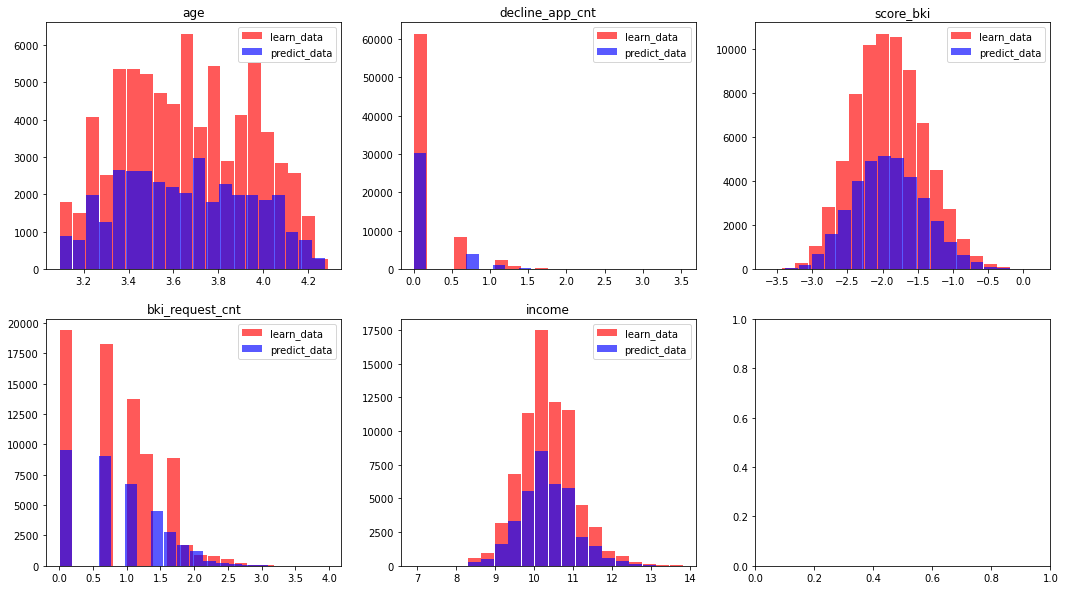

In [6]:
log_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in log_cols:
    data[i] = np.log(1+data[i].values)

plot_train_test_hist(data, num_cols, col_number=3, figsize_=(18, 10), bins_=20)

- распределения признаков в данных для обучения и предсказания схожи, перекосов нет

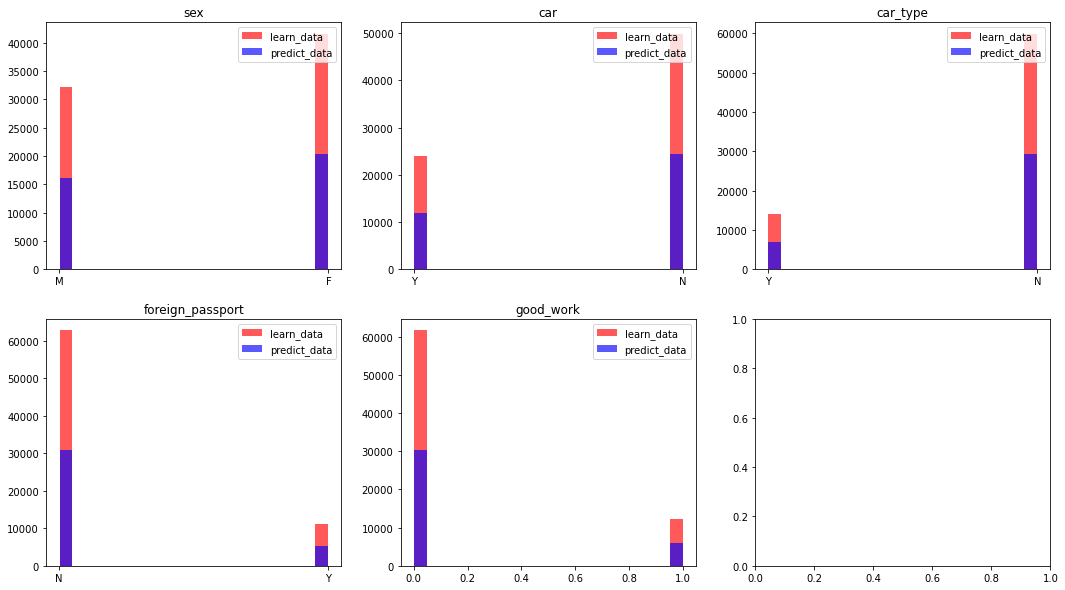

In [7]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
plot_train_test_hist(data, bin_cols, col_number=3, figsize_=(18, 10), bins_=20)

- распределения признаков в данных для обучения и предсказания схожи, перекосов нет

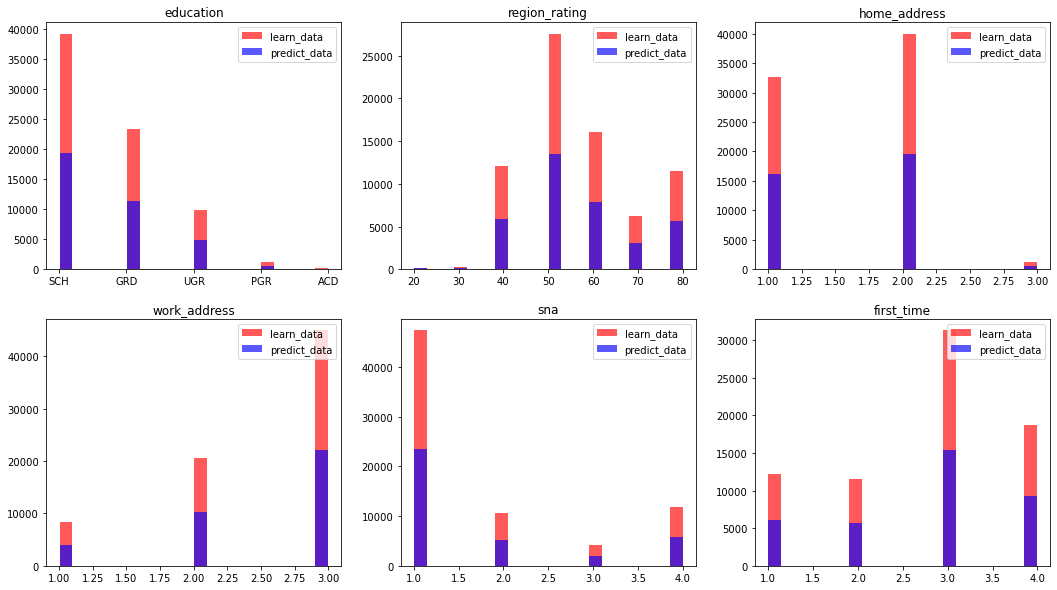

In [8]:
cat_cols = ['education', 'region_rating', 'home_address',
            'work_address', 'sna', 'first_time']
plot_train_test_hist(data, cat_cols, col_number=3, figsize_=(18, 10), bins_=20)

- распределения признаков в данных для обучения и предсказания схожи, перекосов нет

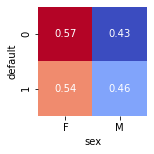

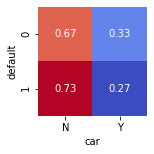

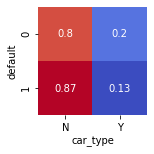

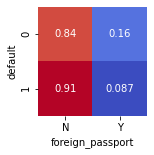

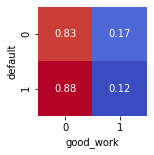

In [9]:
def plot_cross_tab(data_, col_names, target_name, figsize_=(18, 8)):
    for col_name in col_names:
        df = data[data['sample'] == 1]
        df_cross_tab = pd.crosstab(df[target_name], df[col_name], normalize='index')
        df_cross_tab = np.round(df_cross_tab, 3)
        plt.figure(figsize=figsize_)
        sns.heatmap(df_cross_tab, annot=True, square=True,
                    cmap='coolwarm', cbar=False)
        plt.show


plot_cross_tab(data, bin_cols, target_name='default', figsize_=(16, 2))

- явных разделяющих признаков среди категориальных не наблюдается

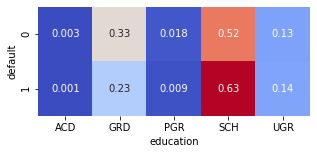

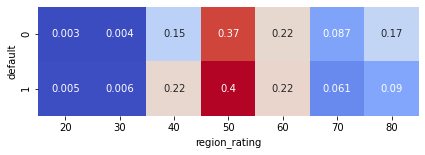

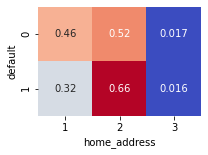

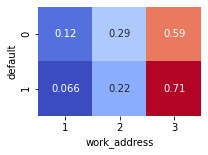

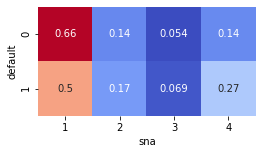

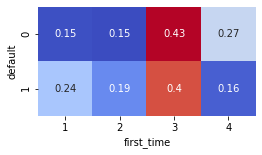

In [10]:
plot_cross_tab(data, cat_cols, target_name='default', figsize_=(16, 2))

- явных разделяющих признаков среди категориальных не наблюдается
- дальнейшее исследование признаков будет проведено с помощью построенной нелинейной модели

# Формирование доп. признаков LabelEncoder, TargetEncoder

In [11]:
# Применяем LabelEncoder для бинарных признаков
col_data = []  # в данный список будем соберать признакми для моделирования
label_encoder = LabelEncoder()
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']
for col_ in bin_cols:
    data[col_] = label_encoder.fit_transform(data[col_])
col_data.extend(bin_cols)
col_data.extend(['good_work'])

In [12]:
# Функции для генерации TargetEncoder для различных статистик
def data_filtr_func(data, agg_filtr_me='', agg_filtr_val=0, sign='=='):
    if agg_filtr_me != '':
        if sign == '==':
            data_filtr = data[data[agg_filtr_me] == agg_filtr_val]
        elif sign == '!=':
            data_filtr = data[data[agg_filtr_me] != agg_filtr_val]
        elif sign == '>=':
            data_filtr = data[data[agg_filtr_me] >= agg_filtr_val]
        elif sign == '>':
            data_filtr = data[data[agg_filtr_me] > agg_filtr_val]
        elif sign == '<=':
            data_filtr = data[data[agg_filtr_me] <= agg_filtr_val]
        elif sign == '<':
            data_filtr = data[data[agg_filtr_me] < agg_filtr_val]
        else:
            data_filtr = []
    else:
        data_filtr = data

    return data_filtr


def agr_me_all(data, by='', count_me='', mean_me='', std_me='', median_me='', sum_me='',
               norm_mean=0, norm_std=0, norm_median=0, norm_count=0, index_str='', agg_filtr_me='',
               agg_filtr_val=0, sign='==', Nan_obj=0):

    data_filtr = data_filtr_func(data, agg_filtr_me, agg_filtr_val, sign)
    temp_col = []

    if (count_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[count_me].agg(['count'])
        data[count_me + '_count' + index_str] = data[by].apply(lambda x: df_temp['count'].loc[x]
                                                               if x in df_temp['count'] else Nan_obj)
        temp_col.extend([count_me + '_count' + index_str])

    if (mean_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[mean_me].agg(['mean'])
        data[mean_me + '_mean' + index_str] = data[by].apply(lambda x: df_temp['mean'].loc[x]
                                                             if x in df_temp['mean'] else Nan_obj)
        temp_col.extend([mean_me + '_mean' + index_str])

    if (std_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[std_me].agg(['std'])
        data[std_me + '_std' + index_str] = data[by].apply(lambda x: df_temp['std'].loc[x]
                                                           if x in df_temp['std'] else Nan_obj)
        temp_col.extend([std_me + '_std' + index_str])

    if (median_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[median_me].agg(['median'])
        data[median_me + '_median' + index_str] = data[by].apply(lambda x: df_temp['median'].loc[x]
                                                                 if x in df_temp['median'] else Nan_obj)
        temp_col.extend([median_me + '_median' + index_str])

    if (sum_me != '') and (by != ''):
        df_temp = data_filtr.groupby(by=by)[sum_me].agg(['sum'])
        data[sum_me + '_sum' + index_str] = data[by].apply(lambda x: df_temp['sum'].loc[x]
                                                           if x in df_temp['sum'] else Nan_obj)
        temp_col.extend([sum_me + '_sum' + index_str])

    if (norm_count == 1) and (by != '') and (count_me != ''):
        data[count_me + "_norm_count" + index_str] = data[count_me] / \
                                                        data[count_me + '_count' + index_str]
        data[count_me + "_norm_count" + index_str] = data[count_me + "_norm_count" + index_str].\
                                                        apply(lambda x: x if not pd.isna(x) else Nan_obj)
        temp_col.extend([count_me + "_norm_count" + index_str])

    if (norm_mean == 1) and (by != '') and (mean_me != ''):
        data[mean_me + "_norm_mean" + index_str] = data[mean_me] - \
                                                    data[mean_me + '_mean' + index_str]
        temp_col.extend([mean_me + "_norm_mean" + index_str])

    if (norm_median == 1) and (by != '') and (median_me != ''):
        data[median_me + "_norm_median" + index_str] = data[median_me] - \
                                                        data[median_me + '_median' + index_str]
        temp_col.extend([median_me + "_norm_median" + index_str])

    if (norm_std == 1) and (by != '') and (mean_me != '') and (std_me != ''):
        data[std_me + "_norm_std" + index_str] = data[mean_me + "_norm_mean" + index_str] / \
                                                        data[std_me + '_std' + index_str]
        data[std_me + "_norm_std" + index_str] = data[std_me + "_norm_std" + index_str]. \
                                                    apply(lambda x: x if not pd.isna(x) else Nan_obj)
        temp_col.extend([std_me + "_norm_std" + index_str])

    return temp_col


def agr_me(data, by='', col='', agg_func='', index_str='', agg_filtr_me='',
           agg_filtr_val=0, sign='==', Nan_obj=0):

    if agg_func == 'count':
        return agr_me_all(data, by=by, count_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'mean':
        return agr_me_all(data, by=by, mean_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'median':
        return agr_me_all(data, by=by, median_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'std':
        return agr_me_all(data, by=by, std_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'sum':
        return agr_me_all(data, by=by, sum_me=col, index_str=index_str, agg_filtr_me=agg_filtr_me,
                          agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_count':
        return agr_me_all(data, by=by, count_me=col, norm_count=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_median':
        return agr_me_all(data, by=by, median_me=col, norm_median=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_mean':
        return agr_me_all(data, by=by, mean_me=col, norm_mean=1, index_str=index_str,
                          agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val, sign=sign, Nan_obj=Nan_obj)
    elif agg_func == 'norm_std':
        return agr_me_all(data, by=by, mean_me=col, std_me=col, norm_mean=1, norm_std=1,
                          index_str=index_str, agg_filtr_me=agg_filtr_me, agg_filtr_val=agg_filtr_val,
                          sign=sign, Nan_obj=Nan_obj)

In [13]:
# Применяем TargetEncoder для категориальных признаков (функции для агрегации count, mean, std)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
for col_name_ in cat_cols:
    col_data.extend(agr_me(data, by=col_name_,
                           col=col_name_, agg_func='count'))
    col_data.extend(agr_me(data, by=col_name_, col='default', agg_func='mean', agg_filtr_me='sample',
                           agg_filtr_val=1, sign='==', Nan_obj=0, index_str='_'+col_name_))
    col_data.extend(agr_me(data, by=col_name_, col='default', agg_func='std', agg_filtr_me='sample',
                           agg_filtr_val=1, sign='==', Nan_obj=0, index_str='_'+col_name_))

In [14]:
# преобразование app_date в формат datetime, формирование доп признаков: день, день недли, месяц
def date_func(x):
    str_ = x[:2] + "/" + x[2:5].replace("JAN", "01").replace("FEB", "02"). \
                                replace("APR", "04").replace("MAR", "03") + "/" + x[5:]
    return datetime.strptime(str_, '%d/%m/%Y')


data.app_date = data.app_date.apply(date_func)

data['date_month'] = data['app_date'].dt.month
data['date_day'] = data['app_date'].dt.day
data['date_weekday'] = data['app_date'].dt.weekday
col_data.extend(['date_month', 'date_weekday', 'date_day'])

In [15]:
# Применяем TargetEncoder для date_month, date_weekday (функции для агрегации count, mean, std)
for col_name_ in ['date_month', 'date_weekday']:
    col_data.extend(agr_me(data, by=col_name_, col=col_name_, agg_func='count'))
    col_data.extend(agr_me(data, by=col_name_, col='default', agg_func='mean', agg_filtr_me='sample',
                           agg_filtr_val=1, sign='==', Nan_obj=0, index_str='_'+col_name_))
    col_data.extend(agr_me(data, by=col_name_, col='default', agg_func='std', agg_filtr_me='sample',
                           agg_filtr_val=1, sign='==', Nan_obj=0, index_str='_'+col_name_))

In [16]:
# Сохраняем результат подготовки признаков
def save_func(data, col_data=None, filename='data_ini.zip', colname="columns_ini.json"):
    data.to_csv(filename, index=False)
    if col_data is not None:
        with open(colname, "w") as f:
            f.write(json.dumps(col_data))


save_func(data, col_data=col_data, filename='data_ini.zip', colname="columns_ini.json")